# Tropical storms of CONUS

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
tracks_file = "/home/simon/Downloads/IBTrACS.ALL.v04r01.nc"
tracks = xr.load_dataset("/home/simon/Downloads/IBTrACS.ALL.v04r01.nc")

In [3]:
time = tracks.time 
inds = ((np.datetime64("2022-01-01") < time) * (time < np.datetime64("2023-01-01"))).any("date_time")
tracks_2022 = tracks[{"storm": inds}]

In [4]:
from tqdm import tqdm
import shapely
from pansat import FileRecord, TimeRange
from pansat.granule import Granule
from pansat.geometry import ShapelyGeometry
from pansat.catalog.index import _granules_to_dataframe

granules = []
for storm in tqdm(range(tracks_2022.storm.size)):
    track_data = tracks_2022[{"storm": storm}]
    n_obs = int(track_data.numobs.item())
    for ind in range(n_obs - 1):
        segment = track_data[{"date_time": slice(ind, ind + 2)}]
        start_time = segment.time[0].data
        end_time = segment.time[1].data
        geometry = ShapelyGeometry(shapely.LineString(np.stack([segment.lon.data, segment.lat.data], -1)))
        granules.append(Granule(
            FileRecord(tracks_file),
            TimeRange(start_time, end_time),
            geometry=geometry,
            primary_index_name="storm",
            primary_index_range=(storm, storm + 1),
            secondary_index_name="date_time",
            secondary_index_range=(ind, ind + 1),
        ))
        
track_index = _granules_to_dataframe(granules)

100%|█████████████████████████████████████████████████████████████████| 113/113 [00:09<00:00, 11.67it/s]


In [5]:
from pansat.products.ground_based.mrms import MRMS_DOMAIN

conus_mask = track_index["geometry"].apply(lambda x: x.intersects(MRMS_DOMAIN.to_shapely()))
tracks_conus = track_index[conus_mask]

In [7]:
from pansat.products.satellite.noaa.gaasp import l1b_gcomw1_amsr2
from pansat.environment import get_index

In [8]:
from pansat.catalog import Index
l1b_index = Index.load(l1b_gcomw1_amsr2, "/edata2/simon/satellite_data/.pansat_catalog/")

In [9]:
dframe = l1b_index.data.load()

In [10]:
mask = dframe["geometry"] == None


In [11]:
dframe[mask]

,start_time,end_time,local_path,remote_path,filename,primary_index_name,primary_index_start,primary_index_end,secondary_index_name,secondary_index_start,secondary_index_end,geometry
150013,2021-01-01 05:22:28,2021-01-01 05:28:28,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202101010422180_e202101010...,scans,2400,2641,pixels_s1,0,243,None
150030,2021-01-01 07:06:23,2021-01-01 07:12:35,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202101010558170_e202101010...,scans,2717,2966,pixels_s1,0,243,None
150055,2021-01-01 09:31:59,2021-01-01 09:38:11,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202101010913180_e202101011...,scans,741,990,pixels_s1,0,243,None
150066,2021-01-01 10:39:54,2021-01-01 10:46:06,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202101010913180_e202101011...,scans,3458,3707,pixels_s1,0,243,None
150226,2021-01-02 09:02:41,2021-01-02 09:08:53,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202101020819170_e202101020...,scans,1729,1978,pixels_s1,0,243,None
...,...,...,...,...,...,...,...,...,...,...,...,...
202123,2021-10-11 14:56:59,2021-10-11 15:02:59,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202110111350490_e202110111...,scans,2640,2881,pixels_s1,0,243,None
202132,2021-10-11 15:51:40,2021-10-11 15:57:52,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202110111526480_e202110111...,scans,988,1237,pixels_s1,0,243,None
202143,2021-10-11 16:59:35,2021-10-11 17:05:47,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202110111526480_e202110111...,scans,3705,3954,pixels_s1,0,243,None
202156,2021-10-11 19:55:54,2021-10-11 20:02:06,/edata2/simon-veljko/2021/GAASP-L1B_v2r2_GW1_s...,None,GAASP-L1B_v2r2_GW1_s202110111847490_e202110112...,scans,2717,2966,pixels_s1,0,243,None


In [12]:
l1b_index = get_index(l1b_gcomw1_amsr2)

Found table named 'reanalysis.era5_surface_hourly_10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_sea_surface_temperature_-158_-54_-128_-21' in database but could not load find a corresponding pansat product.
Found table named 'satellite.goes.l1b_goes18_rad_c02_full_disk' in database but could not load find a corresponding pansat product.
Found table named 'reanalysis.merra.m2i3nvasm' in database but could not load find a corresponding pansat product.
Found table named 'reanalysis.era5_surface_hourly_10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_sea_surface_temperature_-163_-9_-144_6' in database but could not load find a corresponding pansat product.
Found table named 'reanalysis.era5_surface_hourly_10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_sea_surface_temperature_-166_-18_-142_19' in database but could not load find a corresponding pansat product.
Found table named 'reanalysis.era5_pressure_levels_hourly_geopotential_temperature_sp

In [13]:
from pansat.catalog.index import find_matches
matches = find_matches(tracks_conus, l1b_index, n_processes=16)

Output()

In [14]:
print(f"Found {len(matches)} overpasses.")

Found 85 overpasses.


In [15]:
ind = 67
data = list(matches[ind][1])[0].open()

In [16]:
len(matches[ind][1])

1

/tmp/ipykernel_1852882/3025102284.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lons, lats, data.tbs_s1.data[..., -1])


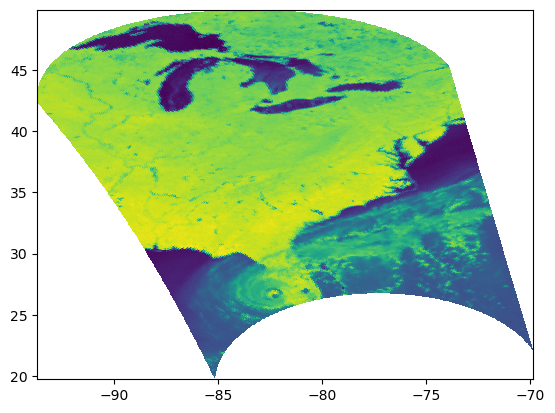

In [17]:
lons = data.longitude_s1
lats = data.latitude_s1
plt.pcolormesh(lons, lats, data.tbs_s1.data[..., -1])

## Run retrieval

In [24]:
from pytorch_retrieve.architectures import load_model
model = load_model("../noaagprof.ckpt")

/home/simon/miniconda3/envs/noaagprof/lib/python3.10/site-packages/pytorch_retrieve/architectures/model.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.l

In [25]:
import toml
from pytorch_retrieve.config import InferenceConfig

iconf = InferenceConfig.parse(model.output_config, toml.load("../inference_config_noaagprof.toml"))
model.inference_config = iconf

In [26]:
from noaagprof import InputLoader
from pytorch_retrieve.inference import run_inference

granule = list(matches[ind][1])[0]

In [27]:
rng = granule.primary_index_range
granule.primary_index_range = (rng[0] - 100, rng[1] + 100)

In [28]:
input_loader = InputLoader(inputs=[granule])

In [29]:
results = run_inference(model, input_loader, iconf)

Output()

## Resample results

In [30]:
import satpy

In [31]:
from pyresample.area_config import create_area_def
area_def = create_area_def(
    'area',
    {'proj': 'longlat', 'datum': 'WGS84'},
    area_extent=[-86, 24, -79, 31],
    resolution=0.02,
    units='degrees',
    description='Global 1x1 degree lat-lon grid'
)

In [32]:
from pansat.utils import resample_data

results_noaagprof = resample_data(results[0], area_def)


In [33]:
results_noaagprof

<xarray.Dataset> Size: 57MB
Dimensions:                       (latitude: 350, longitude: 350, channels: 16,
                                   classes: 4, levels: 28)
Coordinates:
  * latitude                      (latitude) float64 3kB 30.99 30.97 ... 24.01
  * longitude                     (longitude) float64 3kB -85.99 ... -79.01
Dimensions without coordinates: channels, classes, levels
Data variables: (12/16)
    observations                  (latitude, longitude, channels) float32 8MB ...
    spacecraft_longitude          (latitude, longitude) float32 490kB 79.01 ....
    spacecraft_latitude           (latitude, longitude) float32 490kB 79.01 ....
    spacecraft_altitude           (latitude, longitude) float32 490kB 7.079e+...
    scan_time                     (latitude, longitude) datetime64[ns] 980kB ...
    surface_precip                (latitude, longitude) float32 490kB 0.00042...
    ...                            ...
    convective                    (latitude, longitude) float32 490kB -10.93 ...
    convective_precip             (latitude, longitude) float32 490kB 1.294e-...
    rain_water_content            (latitude, longitude, levels) float32 14MB ...
    snow_water_content            (latitude, longitude, levels) float32 14MB ...
    latent_heating                (latitude, longitude, levels) float32 14MB ...
    rain_water_path               (latitude, longitude) float32 490kB 6.388e-...

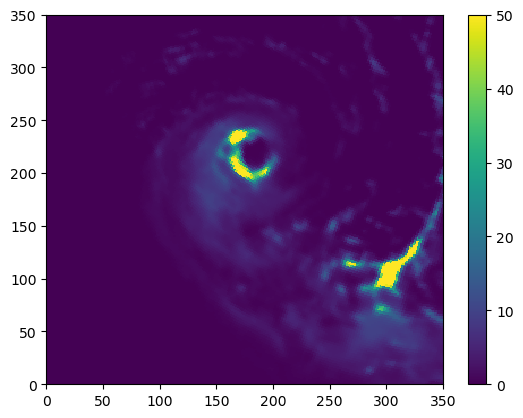

In [34]:
plt.pcolormesh(results_noaagprof.surface_precip, vmin=0, vmax=50)
plt.colorbar()

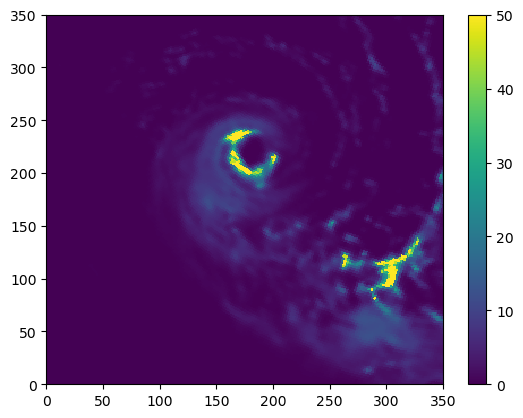

In [45]:
plt.pcolormesh(results_noaagprof.surface_precip, vmin=0, vmax=50)
plt.colorbar()

In [123]:
0.5 * np.arange(20)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

(180.0, 270.0)

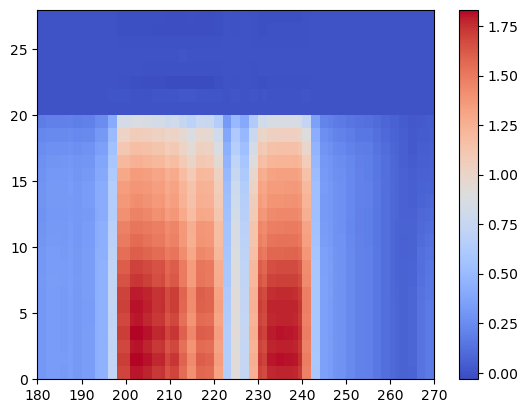

In [35]:
plt.pcolormesh(results_noaagprof.rain_water_content.data[:, 170, :].T, cmap="coolwarm")
plt.colorbar()
plt.xlim(180, 270)

(180.0, 270.0)

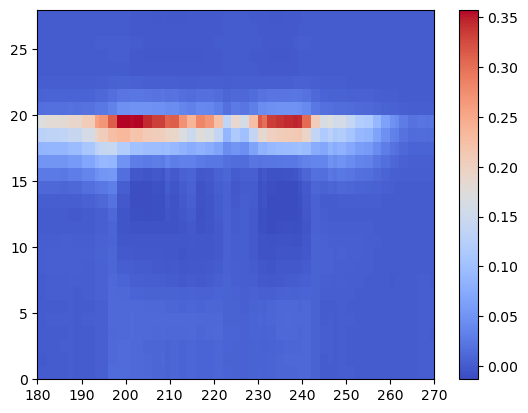

In [47]:
plt.pcolormesh(results_noaagprof.snow_water_content.data[:, 170, :].T, cmap="coolwarm")
plt.colorbar()
plt.xlim(180, 270)

(180.0, 270.0)

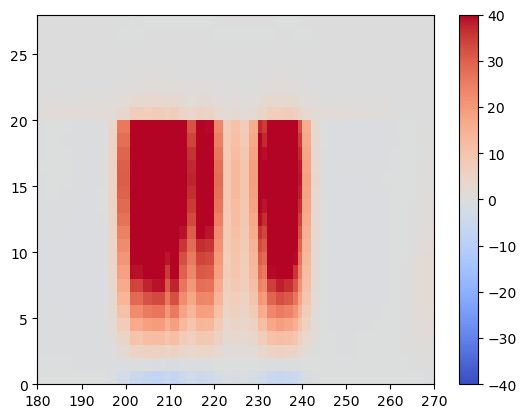

In [46]:
plt.pcolormesh(results_noaagprof.latent_heating.data[:, 170, :].T, cmap="coolwarm", vmin=-40, vmax=40)
plt.colorbar()
plt.xlim(180, 270)

(180.0, 270.0)

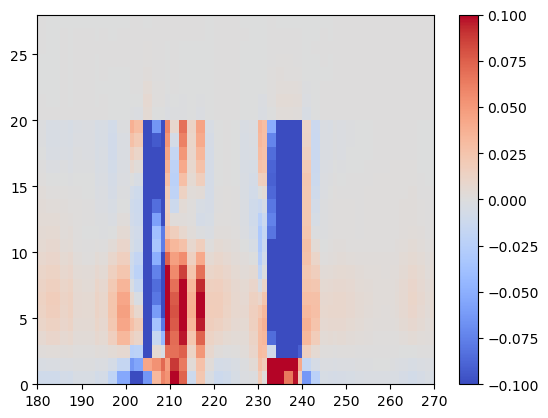

In [114]:
plt.pcolormesh(results_noaagprof.latent_heating.data[:, 170, :].T, cmap="coolwarm", vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.xlim(180, 270)

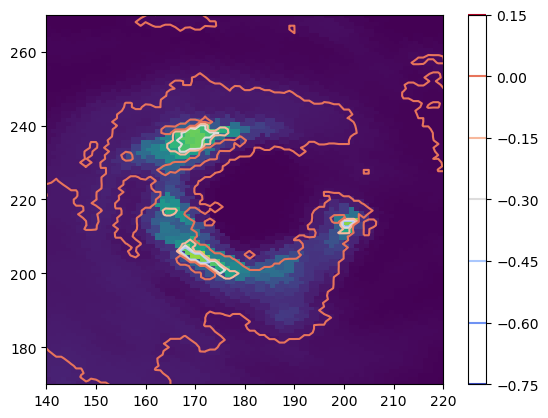

In [99]:
levels = np.linspace(-5, 5, 22)
plt.pcolormesh(results_noaagprof.surface_precip)
plt.xlim(140, 220)
plt.ylim(170, 270)
plt.contour(results_noaagprof.latent_heating[{"levels": 16}], cmap="coolwarm")
plt.colorbar()

## MRMS data

In [50]:
from pansat.products.ground_based.mrms import precip_rate
recs = precip_rate.find_files(granule.time_range)
rec = recs[len(recs) // 2].get()
mrms_data = precip_rate.open(rec)

In [51]:
mrms_data = resample_data(mrms_data, area_def)

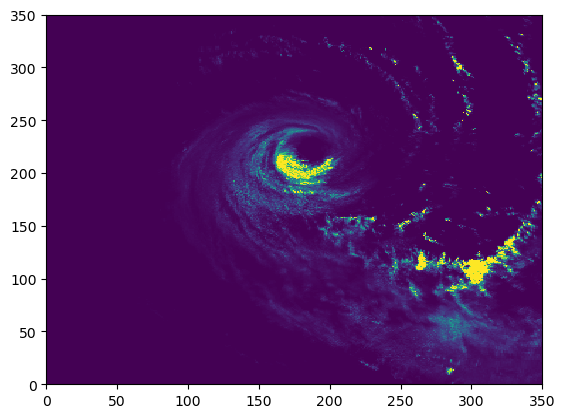

In [52]:
plt.pcolormesh(mrms_data.precip_rate, vmin=0, vmax=50)

## GPROF data

In [ ]:
from pansat.products.satellite.gpm import l2a_gprof_gcomw1_amsr2

recs = l2a_gprof_gcomw1_amsr2.find_files(granule.time_range)
recs[0].get()
gprof_data = l2a_gprof_gcomw1_amsr2.open(recs[0])

In [54]:
gprof_data = resample_data(gprof_data, area_def, radius_of_influence=10e3)

NameError: name 'gprof_data' is not defined

## Plot results

In [ ]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

crs = area_def.to_cartopy_crs()
ext = area_def.area_extent
ext = (ext[0], ext[2], ext[1], ext[3])
gs = GridSpec(1, 4, width_ratios=[1.0, 1.0, 1.0, 0.1])

norm = Normalize(0, 25)
cmap = "magma"

fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(gs[0, 0], projection=crs)
ax.imshow(mrms_data.precip_rate.data, extent=ext, norm=norm, cmap=cmap)
ax.coastlines(color="grey")
ax.set_title("(a) MRMS", loc="left")

ax = fig.add_subplot(gs[0, 1], projection=crs)
ax.imshow(gprof_data.surface_precipitation.data, extent=ext, norm=norm, cmap=cmap)
ax.coastlines(color="grey")
ax.set_title("(b) GPROF V7 AMSR2", loc="left")

ax = fig.add_subplot(gs[0, 2], projection=crs)
m = ax.imshow(results_noaagprof.surface_precip.data, extent=ext, norm=norm, cmap=cmap)
ax.coastlines(color="grey")
ax.set_title("(c) NOAAGPROF", loc="left")

ax = fig.add_subplot(gs[0, 3])
plt.colorbar(m, cax=ax, label="Surface precip [mm/h]")

time_range = granule.time_range
ctime = time_range.start + 0.5 * (time_range.end - time_range.start)
plt.suptitle(ctime.strftime("%Y-%m-%s %H:%M"))



Text(0.5, 0.98, '2022-09-1664411624 18:33')

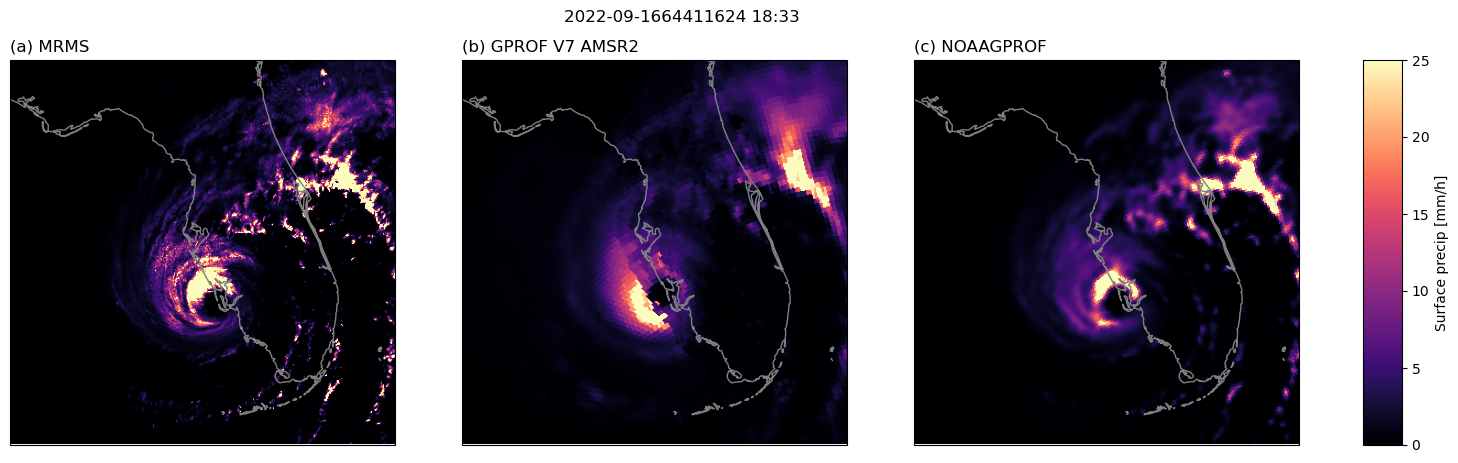

In [514]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

crs = area_def.to_cartopy_crs()
ext = area_def.area_extent
ext = (ext[0], ext[2], ext[1], ext[3])

norm = Normalize(0, 25)
cmap = "magma"

fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(gs[0, 0], projection=crs)
ax.imshow(mrms_data.precip_rate.data, extent=ext, norm=norm, cmap=cmap)
ax.coastlines(color="grey")
ax.set_title("(a) MRMS", loc="left")

ax = fig.add_subplot(gs[0, 1], projection=crs)
ax.imshow(gprof_data.surface_precipitation.data, extent=ext, norm=norm, cmap=cmap)
ax.coastlines(color="grey")
ax.set_title("(b) GPROF V7 AMSR2", loc="left")

ax = fig.add_subplot(gs[0, 2], projection=crs)
m = ax.imshow(results_noaagprof.surface_precip.data, extent=ext, norm=norm, cmap=cmap)
ax.coastlines(color="grey")
ax.set_title("(c) NOAAGPROF", loc="left")

ax = fig.add_subplot(gs[0, 3])
plt.colorbar(m, cax=ax, label="Surface precip [mm/h]")

time_range = granule.time_range
ctime = time_range.start + 0.5 * (time_range.end - time_range.start)
plt.suptitle(ctime.strftime("%Y-%m-%s %H:%M"))




In [497]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [498]:
p_conv = sigmoid(results_noaagprof.convective.data)

In [4]:
from pathlib import Path
test_files = sorted(list(Path("/gdata1/simon/noaagprof/validation_data_cmb/target/").glob("*.nc")))

In [5]:
sp_min = 100
sp_max = -1
for path in test_files:
    with xr.open_dataset(path) as data:
        if data.surface_precip.max().data >= sp_max:
            print(data.surface_precip.max().data, path)
        sp_max = max(sp_max, data.surface_precip.max().data)
        sp_min = min(sp_min, data.surface_precip.min().data)
        if data.surface_precip.max().data > 400:
            path.unlink()
        

3.36 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220601144349.nc
12.5 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220601144434.nc
12.5 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220601144516.nc
12.5 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220601144602.nc
19.39 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220601180004.nc
19.39 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220601180042.nc
19.39 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220601180043.nc
19.39 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220601180122.nc
19.39 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220601180125.nc
24.94 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220606190754.nc
24.94 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220606190826.nc
24.94 /gdata1/simon/noaagprof/validation_data_cmb/target/target_20220606190920.nc
58.870000000000005 /

In [142]:
colloc = xr.load_dataset("/edata2/simon-veljko/collocations/cmb/on_swath/cmb_noaa_amsr2_20220504005245.nc", group="reference_data")

In [147]:
np.all(np.isnan(colloc.surface_precip))

<xarray.DataArray 'surface_precip' ()> Size: 1B
np.False_

In [135]:
%ls -ltrh /edata2/simon-veljko/collocations/cmb/on_swath/

total 155G
-rw-r--r-- 1 32901 users  21M Aug 13 12:12 cmb_noaa_amsr2_20190901172129.nc
-rw-r--r-- 1 32901 users  23M Aug 13 12:12 cmb_noaa_amsr2_20190302045010.nc
-rw-r--r-- 1 32901 users  33M Aug 13 12:21 cmb_noaa_amsr2_20190108020146.nc
-rw-r--r-- 1 32901 users  26M Aug 13 12:21 cmb_noaa_amsr2_20190902162558.nc
-rw-r--r-- 1 32901 users  16M Aug 13 12:22 cmb_noaa_amsr2_20190604005920.nc
-rw-r--r-- 1 32901 users  16M Aug 13 12:31 cmb_noaa_amsr2_20191003155555.nc
-rw-r--r-- 1 32901 users  15M Aug 13 12:33 cmb_noaa_amsr2_20191003191324.nc
-rw-r--r-- 1 32901 users  29M Aug 13 12:57 cmb_noaa_amsr2_20190116144710.nc
-rw-r--r-- 1 32901 users  17M Aug 13 13:18 cmb_noaa_amsr2_20191008202248.nc
-rw-r--r-- 1 32901 users  13M Aug 13 13:20 cmb_noaa_amsr2_20190610002413.nc
-rw-r--r-- 1 32901 users  23M Aug 13 13:23 cmb_noaa_amsr2_20190122235832.nc
-rw-r--r-- 1 32901 users  29M Aug 13 13:28 cmb_noaa_amsr2_20190808080917.nc
-rw-r--r-- 1 32901 users  30M Aug 13 13:39 cmb_noaa_amsr2_20190809085356.nc
-

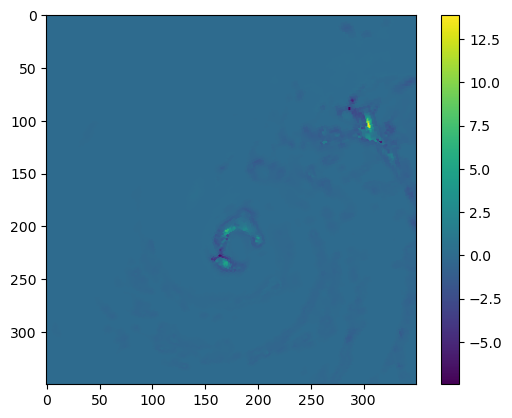

In [133]:
import torch
p_conv = torch.sigmoid(torch.tensor(results_noaagprof.convective.data)).numpy()
sp = results_noaagprof.surface_precip
plt.imshow(p_conv * sp - results_noaagprof.convective_precip.data)
plt.colorbar()

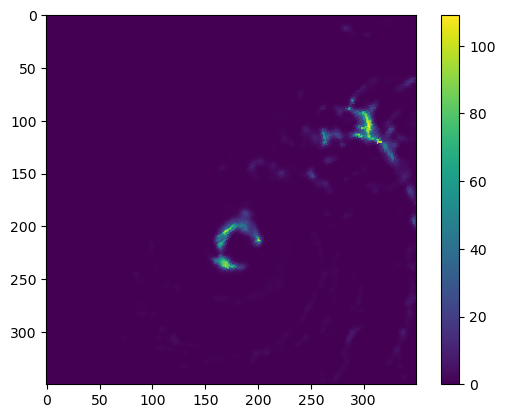

In [132]:
plt.imshow(results_noaagprof.convective_precip)
plt.colorbar()

In [521]:
data = xr.load_dataset("/edata2/simon-veljko/test_data_cmb/target/target_20221102140559.nc")

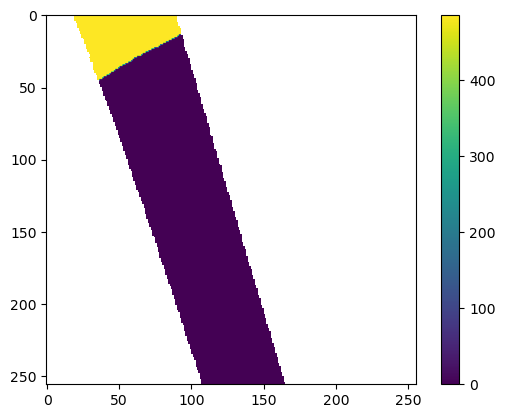

In [524]:
plt.imshow(data.surface_precip)
plt.colorbar()

In [529]:
from pansat import TimeRange
from pansat.products.satellite.gpm import l2b_corra2022_gpm_dprgmi_v07a

recs = l2b_corra2022_gpm_dprgmi_v07a.find_files(TimeRange("2022-11-02T14:05:59"))
rec = recs[0].get()
cmb_data = l2b_corra2022_gpm_dprgmi_v07a.open(rec)

/xdata/simon/speed/raw/satellite.gpm.l2b_corra2022_gpm_dprgmi_v07a.db
/edata2/simon/satellite_data/.pansat_catalog/satellite.gpm.l2b_corra2022_gpm_dprgmi_v07a.db


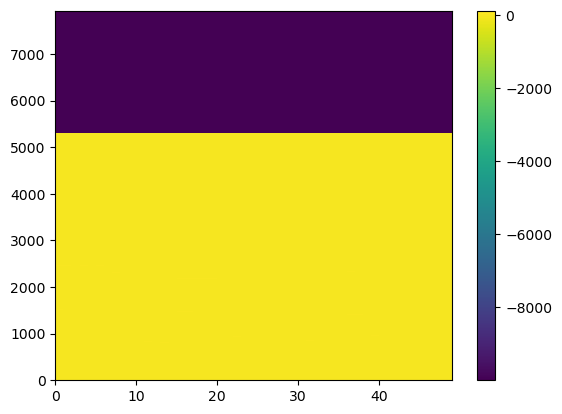

In [535]:
plt.pcolormesh(cmb_data.near_surf_precip_liq_rate)
plt.colorbar()

In [7]:
from noaagprof.training_data import TrainingDataset

ds = TrainingDataset(
    "/gdata1/simon/noaagprof/training_data_cmb/"
)

In [10]:
len(ds.input_files)

25846

In [11]:
len(ds.target_files)

25846

In [12]:
ds.input_files

array([PosixPath('/gdata1/simon/noaagprof/training_data_cmb/noaa/noaa_20190101205554.nc'),
       PosixPath('/gdata1/simon/noaagprof/training_data_cmb/noaa/noaa_20190101205558.nc'),
       PosixPath('/gdata1/simon/noaagprof/training_data_cmb/noaa/noaa_20190101205637.nc'),
       ...,
       PosixPath('/gdata1/simon/noaagprof/training_data_cmb/noaa/noaa_20221231162441.nc'),
       PosixPath('/gdata1/simon/noaagprof/training_data_cmb/noaa/noaa_20221231171400.nc'),
       PosixPath('/gdata1/simon/noaagprof/training_data_cmb/noaa/noaa_20221231171427.nc')],
      dtype=object)

In [13]:
ds.target_files

array([PosixPath('/gdata1/simon/noaagprof/training_data_cmb/target/target_20190101205554.nc'),
       PosixPath('/gdata1/simon/noaagprof/training_data_cmb/target/target_20190101205558.nc'),
       PosixPath('/gdata1/simon/noaagprof/training_data_cmb/target/target_20190101205637.nc'),
       ...,
       PosixPath('/gdata1/simon/noaagprof/training_data_cmb/target/target_20221231162441.nc'),
       PosixPath('/gdata1/simon/noaagprof/training_data_cmb/target/target_20221231171400.nc'),
       PosixPath('/gdata1/simon/noaagprof/training_data_cmb/target/target_20221231171427.nc')],
      dtype=object)

In [56]:
x, y = ds[104]

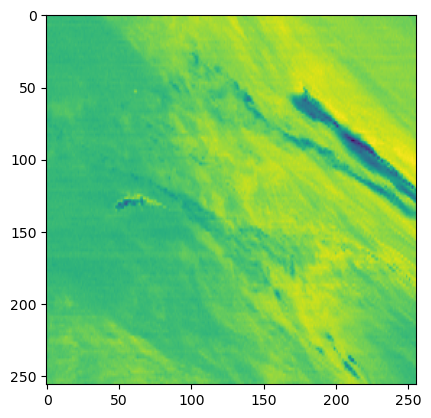

In [60]:
plt.imshow(x[-3])

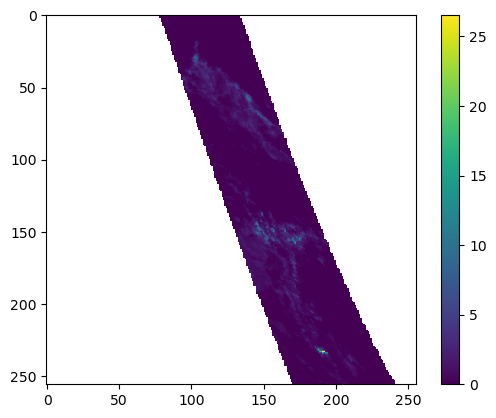

In [61]:
plt.imshow(y["surface_precip"])
plt.colorbar()